**We will explore two different approaches for predicting movie ratings.**
- In the first approach, we will focus on using numerical and categorical features from the data set.

- In the second approach, we will analyze the sentiment of movie reviews to predict the movie ratings.

In both approaches we will compare our models' predictions to actual data to evaluate their performance. 

# First Approach
- using only numerical and categorical features from the data set.

In [2]:
# Import all dependencies

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [3]:
# Download data
df = pd.read_csv('data/rotten_tomatoes_movies.csv')
df.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


**Some initial data understanding**

In [4]:
df.shape

(17712, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                           17398 non-null  float64
 12  prod

In [6]:
df.isna().sum()

rotten_tomatoes_link                   0
movie_title                            0
movie_info                           321
critics_consensus                   8578
content_rating                         0
genres                                19
directors                            194
authors                             1542
actors                               352
original_release_date               1166
streaming_release_date               384
runtime                              314
production_company                   499
tomatometer_status                    44
tomatometer_rating                    44
tomatometer_count                     44
audience_status                      448
audience_rating                      296
audience_count                       297
tomatometer_top_critics_count          0
tomatometer_fresh_critics_count        0
tomatometer_rotten_critics_count       0
dtype: int64

**Converting categorical columns into numbers**
- 'audience_status', 'content_rating' and 'tomatometer_status'

In [7]:
# Make a copy of original data frame before you start manipulating it
df_movie = df.copy()

[Text(0, 0, '9390'), Text(0, 0, '7874')]

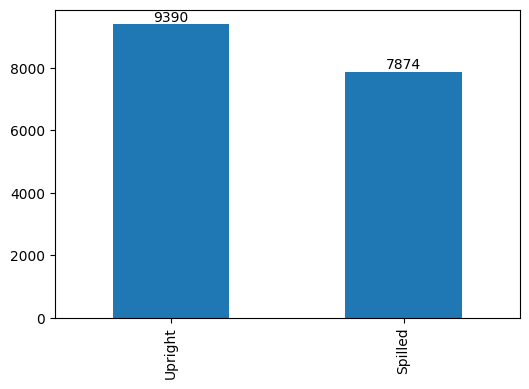

In [8]:
ax = df_movie.audience_status.value_counts().plot(kind='bar', figsize=(6, 4))
ax.bar_label(ax.containers[0])

In [9]:
df_movie = df_movie.dropna(subset=['audience_status', 'tomatometer_status'])

In [10]:
# Using Ordinal encoder on audience_status and tomatometer_status since there is a order in the categoriacal fatures

oe = OrdinalEncoder(categories=[['Spilled', 'Upright']])
df_movie['audience_status'] = oe.fit_transform(df_movie[['audience_status']])

# # Display the learned categories
display(oe.categories_)


[array(['Spilled', 'Upright'], dtype=object)]

In [11]:
oe = OrdinalEncoder(categories=[['Rotten', 'Fresh', 'Certified-Fresh']])
df_movie['tomatometer_status'] = oe.fit_transform(df_movie[['tomatometer_status']])

[Text(0, 0, '6283'),
 Text(0, 0, '5194'),
 Text(0, 0, '2928'),
 Text(0, 0, '2137'),
 Text(0, 0, '675'),
 Text(0, 0, '38')]

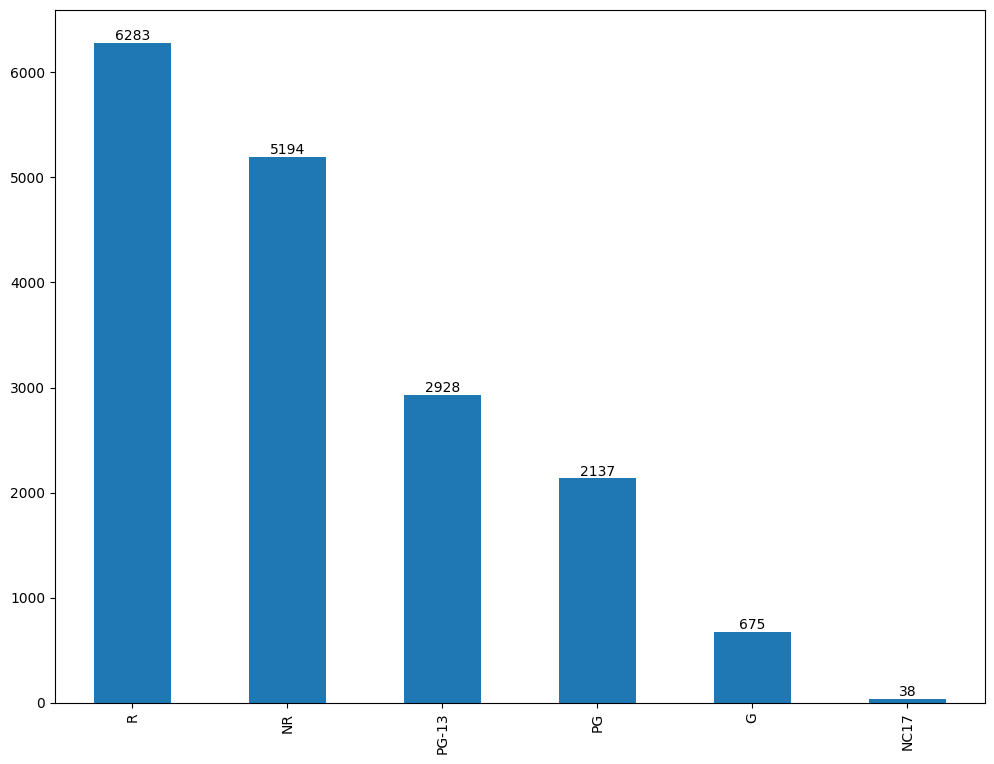

In [12]:
ax = df_movie.content_rating.value_counts().plot(kind='bar', figsize = (12,9))
ax.bar_label(ax.containers[0])

In [13]:
# Using one hot encoding on content_rating as their is no order in the categorical variables.
df_movie = pd.get_dummies(df_movie, columns=['content_rating'])

In [14]:
df_movie.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,genres,directors,authors,actors,original_release_date,streaming_release_date,...,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,content_rating_G,content_rating_NC17,content_rating_NR,content_rating_PG,content_rating_PG-13,content_rating_R
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,...,254421.0,43,73,76,0,0,0,1,0,0
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2012-09-04,...,11574.0,44,123,19,0,0,0,0,0,1
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,2014-07-24,...,14684.0,2,16,8,0,0,0,0,0,1
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2017-01-13,...,105386.0,6,54,0,0,0,1,0,0,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...","Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2016-06-10,...,68918.0,5,24,3,1,0,0,0,0,0


**We will use only few numerical columns for this exercise as not all columns have relevance to the target variable**

In [15]:
numerical_col = ['runtime', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_rating', 'audience_count',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'audience_status',
       'content_rating_G', 'content_rating_NC17', 'content_rating_NR',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_R']

In [16]:
num_df = df_movie[numerical_col]
num_df.head()

,runtime,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,audience_status,content_rating_G,content_rating_NC17,content_rating_NR,content_rating_PG,content_rating_PG-13,content_rating_R
0,119.0,0.0,49.0,149.0,53.0,254421.0,43,73,76,0.0,0,0,0,1,0,0
1,90.0,2.0,87.0,142.0,64.0,11574.0,44,123,19,1.0,0,0,0,0,0,1
2,122.0,1.0,67.0,24.0,53.0,14684.0,2,16,8,0.0,0,0,0,0,0,1
3,95.0,2.0,100.0,54.0,97.0,105386.0,6,54,0,1.0,0,0,1,0,0,0
4,127.0,1.0,89.0,27.0,74.0,68918.0,5,24,3,1.0,1,0,0,0,0,0


In [17]:
# Drop any missing values from the dataframe
num_df = num_df.dropna()
num_df.isna().sum()

runtime                             0
tomatometer_status                  0
tomatometer_rating                  0
tomatometer_count                   0
audience_rating                     0
audience_count                      0
tomatometer_top_critics_count       0
tomatometer_fresh_critics_count     0
tomatometer_rotten_critics_count    0
audience_status                     0
content_rating_G                    0
content_rating_NC17                 0
content_rating_NR                   0
content_rating_PG                   0
content_rating_PG-13                0
content_rating_R                    0
dtype: int64

In [18]:
# Final shape of our datframe that we will work on
num_df.shape

(17017, 16)

[Text(0, 0, '7375'), Text(0, 0, '6475'), Text(0, 0, '3167')]

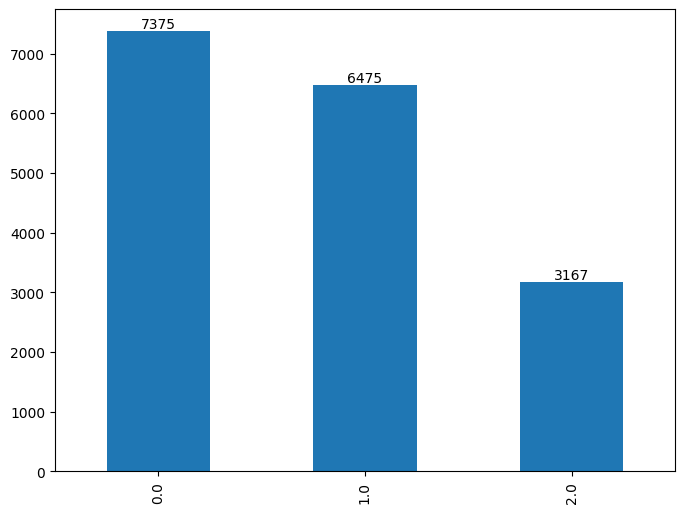

In [19]:
# Lets check the distribution of the classes in our target variable

ax = num_df.tomatometer_status.value_counts().plot(kind='bar', figsize=(8,6))
ax.bar_label(ax.containers[0])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(num_df.drop('tomatometer_status', axis=1),\
                                                    num_df.tomatometer_status, test_size= 0.2,\
                                                   random_state = 5)
print(f'Length of train set is {len(X_train)} and length of test set is {len(X_test)}')

Length of train set is 13613 and length of test set is 3404


**Using Decision Tree Classifier**

In [21]:
#Instantiate Decison tree classifier with max 3 leaf nodes
dt_3_leaf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=5)

In [22]:
dt_3_leaf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=5)

In [23]:
y_predict = dt_3_leaf.predict(X_test)

In [24]:
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

0.9456521739130435
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.98      0.88      0.92      1272
         2.0       0.80      0.96      0.87       644

    accuracy                           0.95      3404
   macro avg       0.92      0.94      0.93      3404
weighted avg       0.95      0.95      0.95      3404



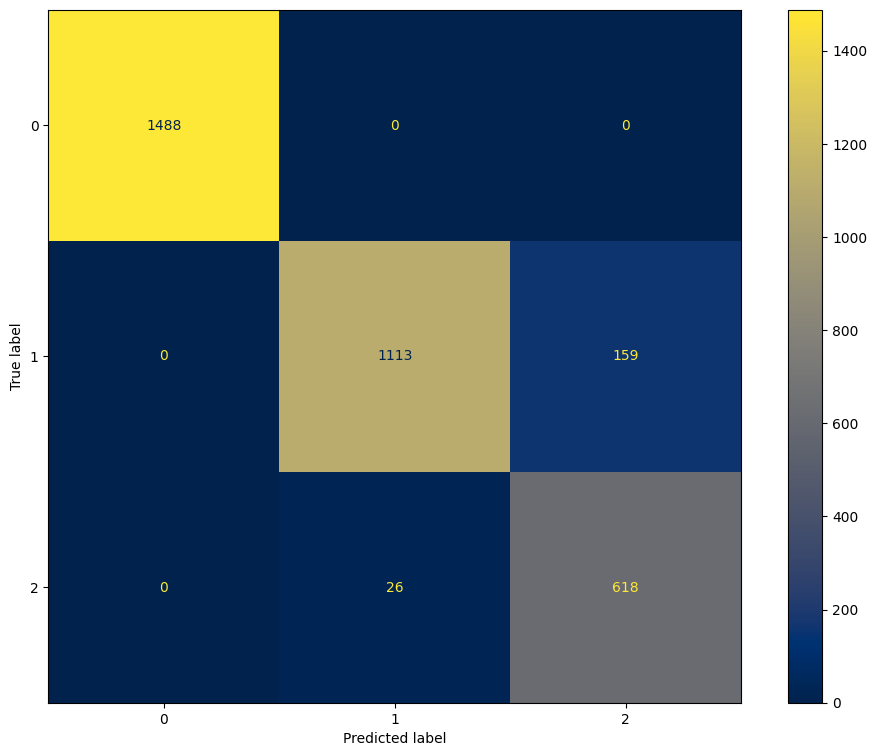

In [25]:
cm = confusion_matrix(y_test, y_predict)

# Assuming dt_3_leaf is your trained model, and X_test and y_test are your test data
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='cividis', ax=ax)
plt.show()

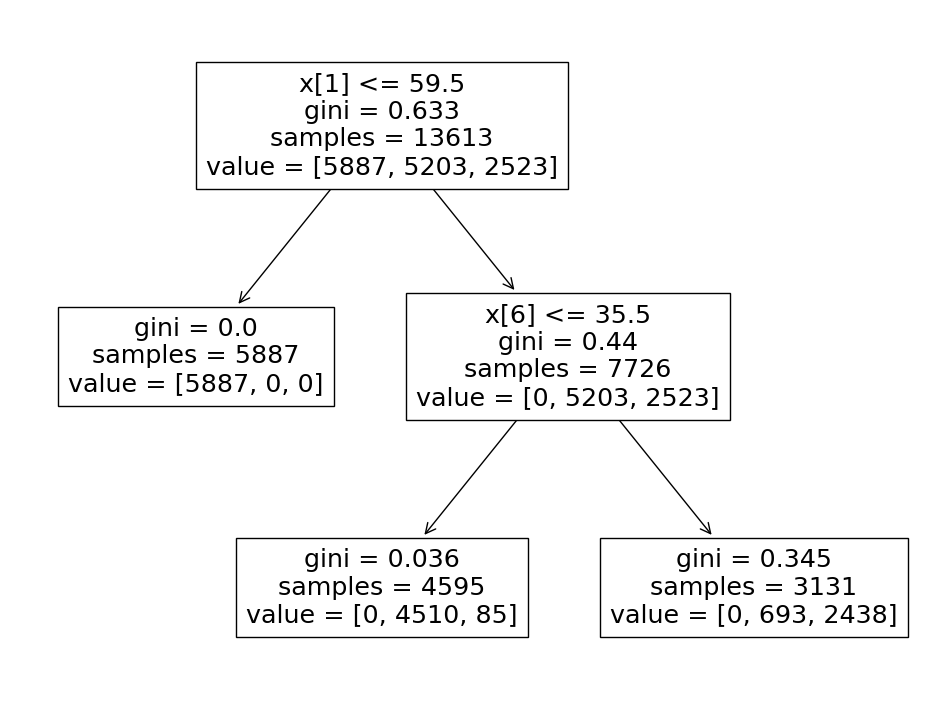

In [26]:
fig, ax = plt.subplots(figsize=(12,9))
plot_tree(dt_3_leaf, ax=ax)
plt.show()

In [27]:
X_train.head()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,audience_status,content_rating_G,content_rating_NC17,content_rating_NR,content_rating_PG,content_rating_PG-13,content_rating_R
2818,129.0,93.0,174.0,74.0,20675.0,42,161,13,1.0,0,0,0,0,1,0
2348,120.0,69.0,197.0,66.0,2272.0,37,136,61,1.0,0,0,0,0,1,0
60,77.0,84.0,50.0,84.0,1854.0,22,42,8,1.0,0,0,1,0,0,0
14314,111.0,75.0,20.0,88.0,7880.0,8,15,5,1.0,0,0,0,0,0,1
13528,93.0,50.0,12.0,36.0,134.0,6,6,6,0.0,0,0,1,0,0,0


0.9900117508813161
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1272
         2.0       0.98      0.97      0.97       644

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



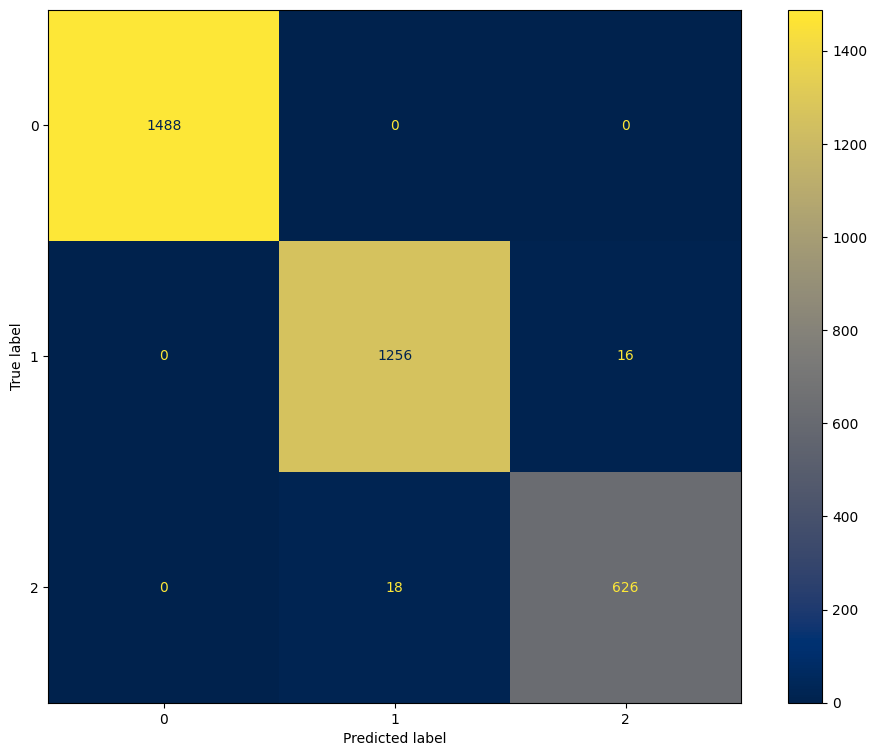

In [28]:
#Instantiate decision tree classifier with default values
dt = DecisionTreeClassifier(random_state=5)

#Train the classifier on train data
dt.fit(X_train, y_train)

#Predcit using test data
y_predict = dt.predict(X_test)

#print accuracy and classification report on test data
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))


#plot confucion matrix on test data
cm = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='cividis', ax=ax)
plt.show()


**Using Random Forest Classifier**

0.9929494712103408
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      1.00      0.99      1272
         2.0       0.99      0.97      0.98       644

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



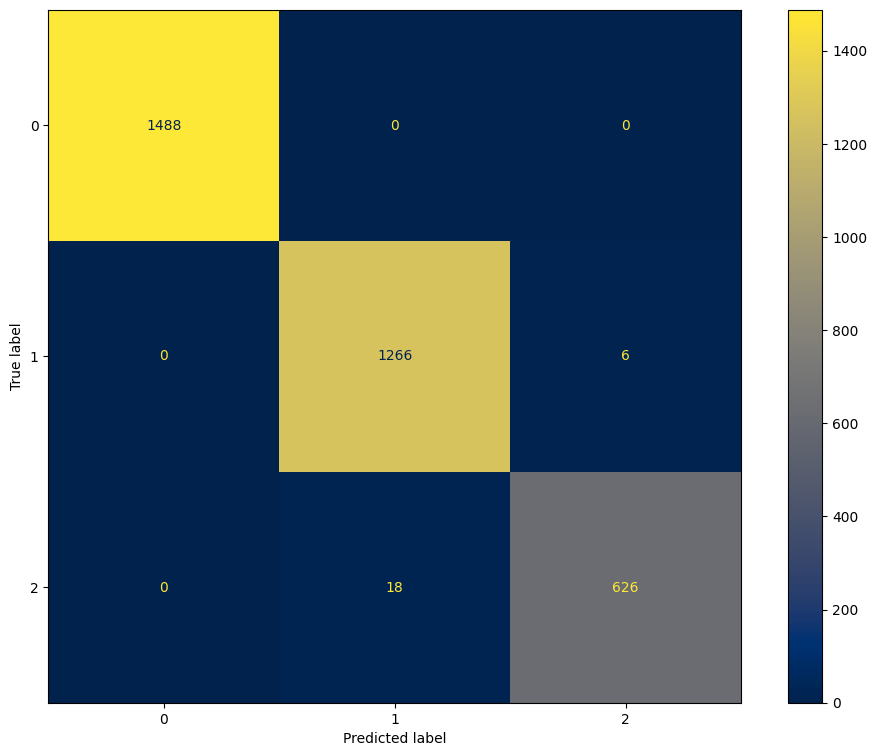

In [29]:
#Instantiate Random forest classifier with default values
rf = RandomForestClassifier(random_state=5)

#Train the classifier on train data
rf.fit(X_train, y_train)

#Predcit using test data
y_predict = rf.predict(X_test)

#print accuracy and classification report on test data
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))


#plot confucion matrix on test data
cm = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='cividis', ax=ax)
plt.show()

runtime 0.006
tomatometer_rating 0.473
tomatometer_count 0.097
audience_rating 0.053
audience_count 0.016
tomatometer_top_critics_count 0.037
tomatometer_fresh_critics_count 0.15
tomatometer_rotten_critics_count 0.122
audience_status 0.03
content_rating_G 0.0
content_rating_NC17 0.0
content_rating_NR 0.011
content_rating_PG 0.001
content_rating_PG-13 0.001
content_rating_R 0.003


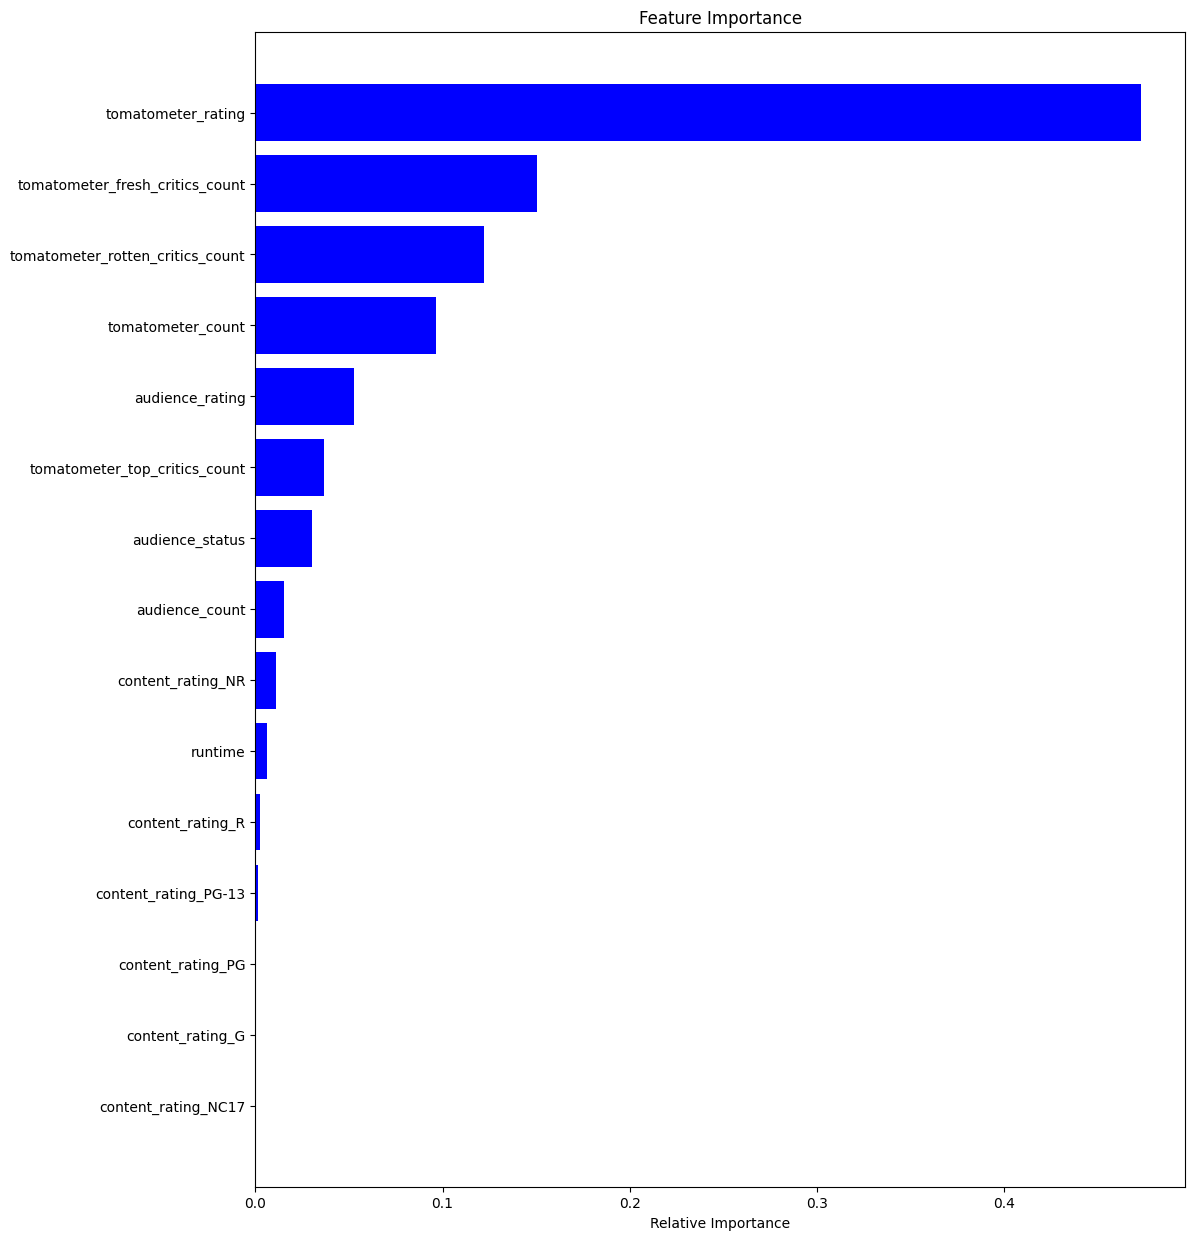

In [30]:
# Get feature importance
feature_importance = rf.feature_importances_
feature_importance

# print feature importance
for i, feature in enumerate(X_train.columns):
    print(f'{feature} {round(feature_importance[i], 3)}')
    
# Visualise feature importance from most to least importance
indicies = np.argsort(feature_importance)
indicies

#plot the feature importances
plt.figure(figsize=(12,15))
plt.title('Feature Importance')
plt.barh(range(len(indicies)), feature_importance[indicies], color='b', align='center')
plt.yticks(range(len(indicies)), [X_train.columns[i] for i in indicies])
plt.xlabel('Relative Importance')
plt.show()



**Removing less important features and using Random Forest Classifier**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(num_df.drop(['tomatometer_status', 'runtime', 'content_rating_R', 'content_rating_PG-13',\
                                                                 'content_rating_PG', 'content_rating_G', 'content_rating_NC17'],\
                                                                axis=1),num_df.tomatometer_status, test_size= 0.2, random_state = 5)
print(
    f'Length of train set is {len(X_train)} and length of test set is {len(X_test)}'
)

Length of train set is 13613 and length of test set is 3404


0.9938307873090482
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      1.00      0.99      1272
         2.0       0.99      0.98      0.98       644

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



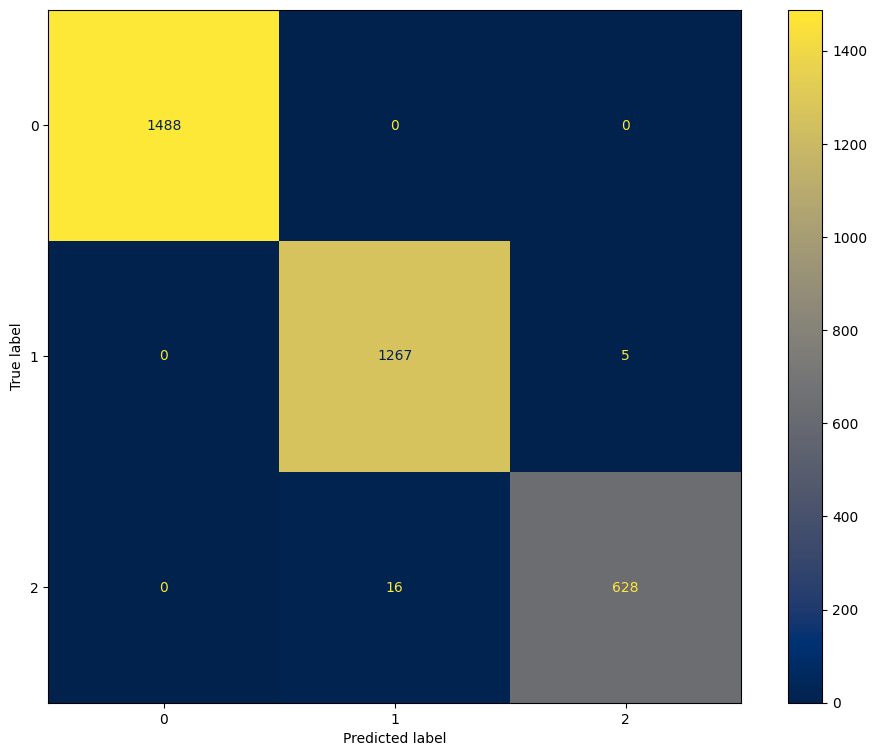

In [32]:
#Instantiate Random forest classifier with default values
rf2 = RandomForestClassifier(random_state=5)

#Train the classifier on train data
rf2.fit(X_train, y_train)

#Predcit using test data
y_predict = rf2.predict(X_test)

#print accuracy and classification report on test data
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))


#plot confucion matrix on test data
cm = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='cividis', ax=ax)
plt.show()

#### For an unbalanced target variable, use class weights and then instantiate a complying model using class weights

In [33]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(
                                        num_df.tomatometer_status),
                                    y=num_df.tomatometer_status.values)

class_weight_dict = dict(zip(range(len(class_weight.tolist())), class_weight.tolist()))
class_weight_dict

{0: 0.7691299435028248, 1: 0.8760360360360361, 2: 1.7910746237238186}

0.9941245593419507
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      1.00      0.99      1272
         2.0       0.99      0.98      0.98       644

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



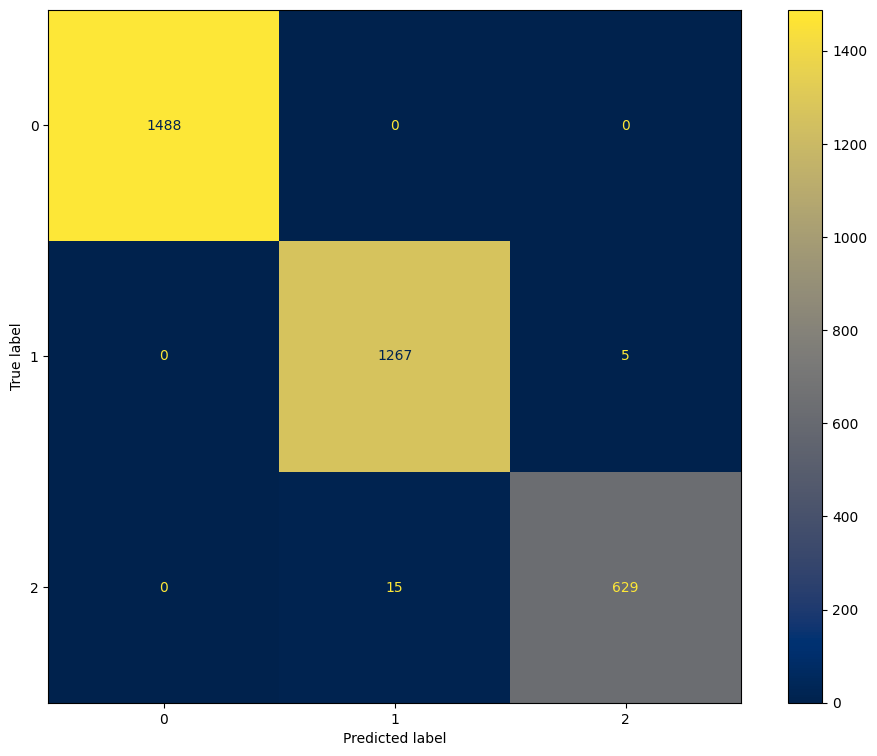

In [34]:
rf_weighted = RandomForestClassifier(class_weight=class_weight_dict, random_state=5)

#Train the classifier on train data
rf_weighted.fit(X_train, y_train)

#Predcit using test data
y_predict = rf_weighted.predict(X_test)

#print accuracy and classification report on test data
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))


#plot confucion matrix on test data
cm = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='cividis', ax=ax)
plt.show()

In [35]:
y_predict

array([1., 0., 0., ..., 0., 2., 0.])

# Second approach
**Using text data to predict movie rating**

In [36]:
#Read movie data
df_movie = pd.read_csv('data/rotten_tomatoes_movies.csv')

# Read critics dataframe
df_critics = pd.read_csv('data/rotten_tomatoes_critic_reviews.csv')
# df_critics = df_critics[:20000]

In [37]:
df_critics.shape, df_movie.shape

((1130017, 8), (17712, 22))

In [38]:
# Merge both dataframes
df_merged = df_critics.merge(df_movie, how='inner', on='rotten_tomatoes_link')
df_merged = df_merged[['rotten_tomatoes_link', 'movie_title', 'review_content', 'review_type', 'tomatometer_status']]

In [39]:
df_merged.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Uma Thurman as Medusa, the gorgon with a coiff...",Fresh,Rotten
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,With a top-notch cast and dazzling special eff...,Fresh,Rotten
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Whether audiences will get behind The Lightnin...,Fresh,Rotten
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,What's really lacking in The Lightning Thief i...,Rotten,Rotten


In [40]:
df_merged.shape

(1129887, 5)

[Text(0, 0, '680954'), Text(0, 0, '383155')]

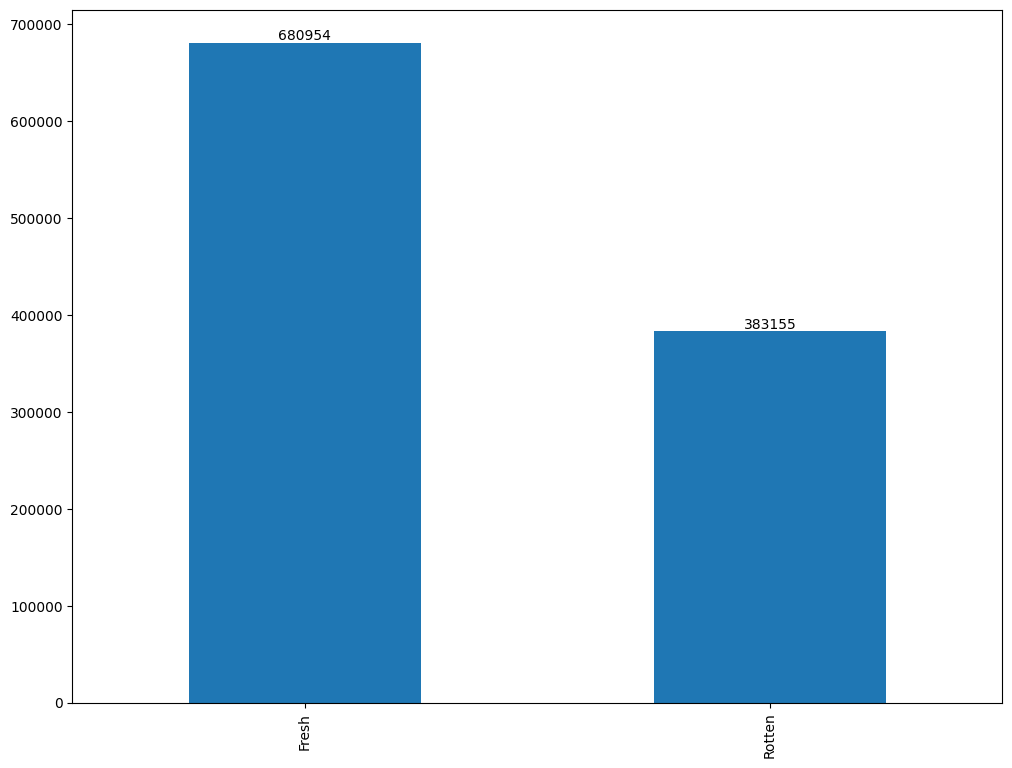

In [41]:
# drop missing values from review_content
df_merged = df_merged.dropna(subset='review_content')

# # Plot the distribution of the review_content
ax = df_merged.review_type.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

In [42]:
# Picking only 10000 entries to speed up the processing
df_merged = df_merged[:5000]

# Encode the review_type
oe = OrdinalEncoder(categories=[['Rotten', 'Fresh']])
df_merged['review_type'] = oe.fit_transform(df_merged[['review_type']])

df_merged.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,1.0,Rotten
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Uma Thurman as Medusa, the gorgon with a coiff...",1.0,Rotten
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,With a top-notch cast and dazzling special eff...,1.0,Rotten
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Whether audiences will get behind The Lightnin...,1.0,Rotten
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,What's really lacking in The Lightning Thief i...,0.0,Rotten


In [43]:
# SPlit the data into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(
    df_merged['review_content'],
    df_merged['review_type'],
    test_size=0.2,
    random_state=5)

0.674
              precision    recall  f1-score   support

         0.0       0.65      0.62      0.64       460
         1.0       0.69      0.72      0.70       540

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



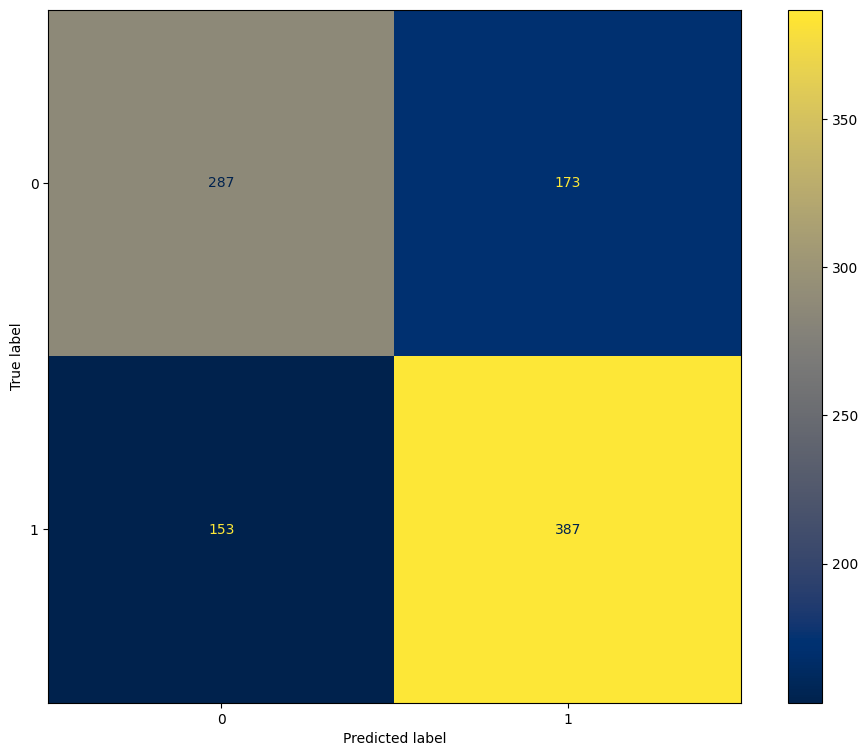

In [44]:
# Covert review_content into vectore, instantiate a Count Vectoriser
vectoriser = CountVectorizer()

# Convert text data into vectors
X_train_vec = vectoriser.fit_transform(X_train).toarray()

#Instantiate Random forest classifier with default values
rf = RandomForestClassifier(random_state=5)

#Train the classifier on train data
rf.fit(X_train_vec, y_train)

#Predcit using test data
y_predict = rf.predict(vectoriser.transform(X_test).toarray())

#print accuracy and classification report on test data
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))


#plot confucion matrix on test data
cm = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='cividis', ax=ax)
plt.show()

**Improve the performance by balancing the target values using class weights**

In [45]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(
                                        df_merged['review_type']),
                                    y=df_merged['review_type'].values)

class_weight_dict = dict(zip(range(len(class_weight.tolist())), class_weight.tolist()))
class_weight_dict

{0: 1.058425063505504, 1: 0.9476876421531463}

0.678
              precision    recall  f1-score   support

         0.0       0.64      0.69      0.66       460
         1.0       0.72      0.67      0.69       540

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000



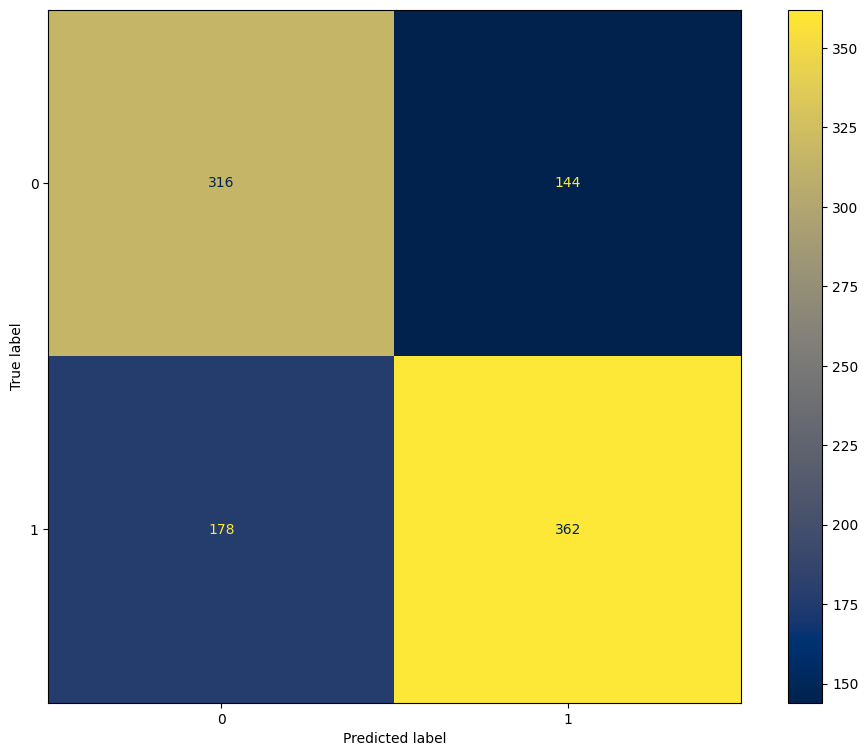

In [46]:
#Instantiate Random forest classifier with default values
rf_weighted_2 = RandomForestClassifier(class_weight=class_weight_dict, random_state=5)

#Train the classifier on train data
rf_weighted_2.fit(X_train_vec, y_train)

#Predcit using test data
y_predict = rf_weighted_2.predict(vectoriser.transform(X_test).toarray())

#print accuracy and classification report on test data
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))


#plot confucion matrix on test data
cm = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='cividis', ax=ax)
plt.show()

In [47]:
# Function to preidct a movie status based on overall sentimet
def predict_movie_status(prediction):
    # Assign label Fresh/Rotten based on prediction
    postive_percentage = (prediction == 1).sum() / len(prediction) * 100
    prediction = 'Fresh' if postive_percentage >= 60 else 'Rotten'
    
    print(f'Positive Percentage: {postive_percentage:.2f}%')
    print(f'Movie Status: {prediction}')  
    
    

**Predictio for Run Fatboy Run**

In [53]:
bol_df = df_merged.loc[df_merged['movie_title'] == 'Run Fatboy Run']
bol_df.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
4630,m/10008621-run_fat_boy_run,Run Fatboy Run,Predictable sitcom but delightfully feel-goodish.,1.0,Rotten
4631,m/10008621-run_fat_boy_run,Run Fatboy Run,"Enjoyable, sharply written and frequently hila...",1.0,Rotten
4632,m/10008621-run_fat_boy_run,Run Fatboy Run,Pegg exudes his usual air of faint self-congra...,0.0,Rotten
4633,m/10008621-run_fat_boy_run,Run Fatboy Run,"An enjoyable if patchy and predictable ride, b...",1.0,Rotten
4634,m/10008621-run_fat_boy_run,Run Fatboy Run,"You'll laugh a bit, but not much, while your i...",0.0,Rotten


In [54]:
# Get the prediction
y_predict_bol = rf_weighted_2.predict(vectoriser.transform(bol_df['review_content']).toarray())
predict_movie_status(y_predict_bol)

Positive Percentage: 44.37%
Movie Status: Rotten


In [58]:
# Get the True label
df_merged['tomatometer_status'].loc[df_merged['movie_title'] == 'Run Fatboy Run'].unique()

array(['Rotten'], dtype=object)

**Prediction for The Matador**

In [59]:
the_mat_df = df_merged.loc[df_merged['movie_title'] == 'The Matador']
y_predict_mat = rf_weighted_2.predict(vectoriser.transform(the_mat_df['review_content']).toarray())
predict_movie_status(y_predict_mat)

Positive Percentage: 70.95%
Movie Status: Fresh


In [60]:
# Get the True label
df_merged['tomatometer_status'].loc[df_merged['movie_title'] == 'The Matador'].unique()

array(['Certified-Fresh'], dtype=object)

**Prediction for the movie The Happening**

In [61]:
the_hap_df = df_merged.loc[df_merged['movie_title'] == 'The Happening']
y_predict_hap = rf_weighted_2.predict(vectoriser.transform(the_hap_df['review_content']).toarray())
predict_movie_status(y_predict_hap)

Positive Percentage: 17.13%
Movie Status: Rotten


In [62]:
# Get the True label
df_merged['tomatometer_status'].loc[df_merged['movie_title'] == 'The Happening'].unique()

array(['Rotten'], dtype=object)